# Exact Indexing of Dynamic Time Warping

**Artur Dandolini Pescador**

This notebook tries to implement the Exact Indexing of Dynamic Time Warping proposed 

[1] Eamonn Keogh and Chotirat Ann Ratanamahatana. 2005. Exact Indexing of Dynamic Time Warping. Knowledge and Information Systems 7, 358–386. Springer. [Link to the paper](https://link.springer.com/article/10.1007/s10115-004-0154-9).


## 1. Introduction

## 2. Packages

In [93]:
import numpy as np
import matplotlib.pyplot as plt

In [94]:
%load_ext autoreload
%autoreload 2

from data_preprocessing import load_and_process_data, normalize_timeseries
from plotting import plot_timeseries, plot_query_database_with_bounds, plot_sequence_with_paa, plot_sequence_with_bounds_and_paa, plot_matches_knn_search, plot_range_search_results
from dtw_functions import paa, create_paa_bounds, lb_paa, dtw_distance
from indexed_structure import IndexedStructure
from indexing import knn_search, range_search
import pandas as pd


from experimental_evaluation import compute_P, compute_T, perform_experiment_T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
%reload_ext autoreload

## 3. Loading Data

In [96]:
# Carregando e processando os dados
timeseries = load_and_process_data('sunspots.csv')

In [97]:
timeseries.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


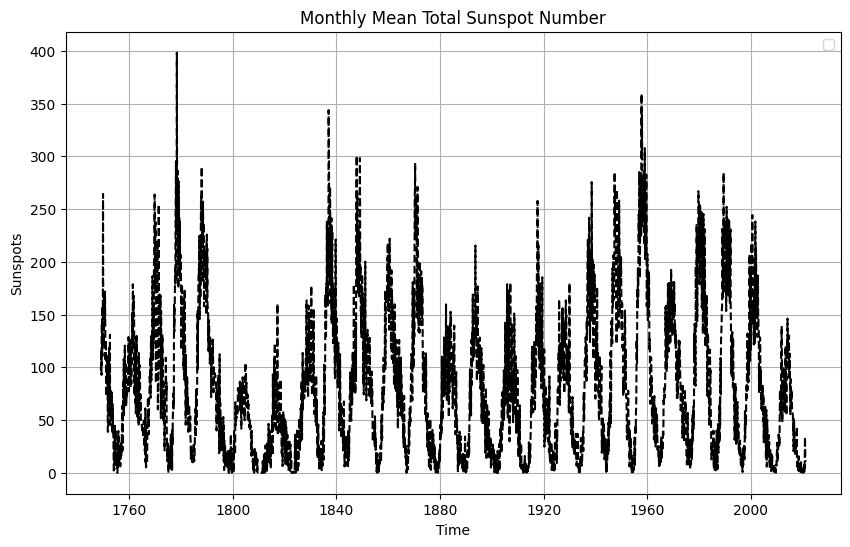

In [98]:
# Plotando a série temporal
plot_timeseries(timeseries.index, timeseries['Monthly Mean Total Sunspot Number'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


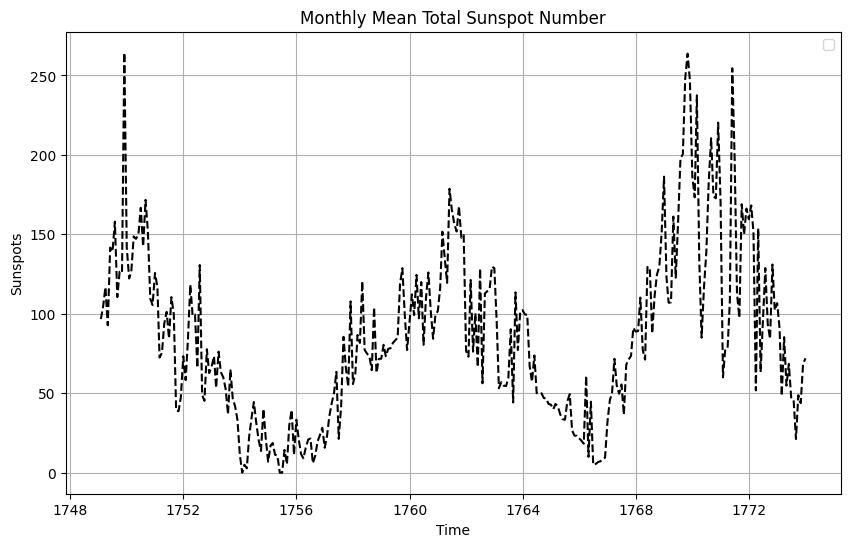

In [99]:
# zoom into the plot, the seasonality is roughly 11 years
plot_timeseries(timeseries.index[:300], timeseries['Monthly Mean Total Sunspot Number'][:300])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


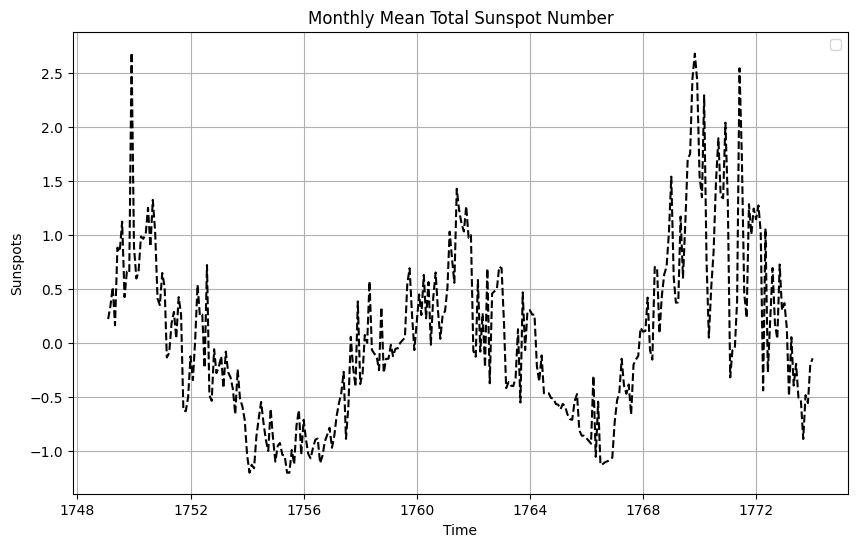

In [100]:
#  normalizando a série temporal
timeseries = normalize_timeseries(timeseries)


# Plotando a série temporal normalizada
plot_timeseries(timeseries.index[:300], timeseries['Monthly Mean Total Sunspot Number'][:300])

## 4. Lower Bouding the DTW distance

### 2.1 Proposed Lower Bounding Measure

$$U_i = max({q_{i-r} : q_{i+r}})$$
$$L_i = min({q_{i-r} : q_{i+r}})$$

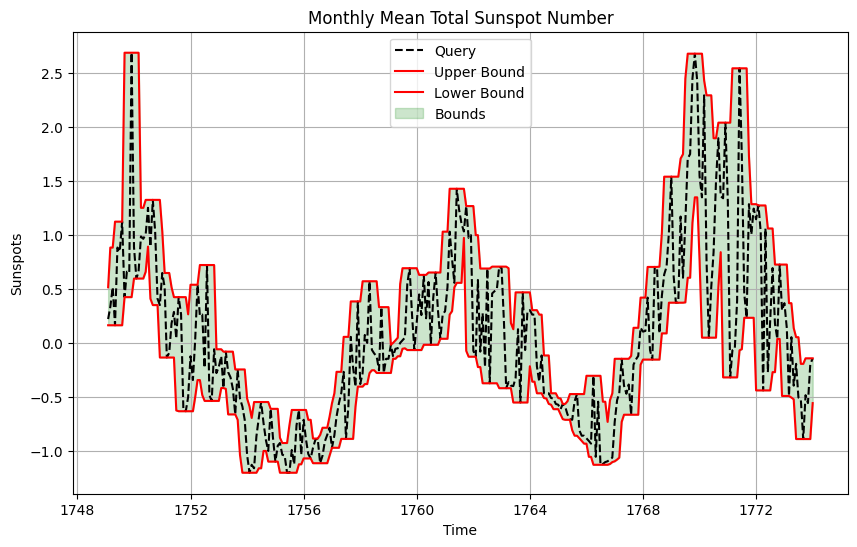

In [101]:
sunspots = np.array(timeseries['Monthly Mean Total Sunspot Number'])

# query and database sequences
x = sunspots[:300] # query
y = sunspots[300:600] # database
r = 3 # warping window

# Calculate the Upper and Lower sequences using the provided formula
U = [max(x[max(i-r, 0):min(i+r+1, len(x))]) for i in range(len(x))]
L = [min(x[max(i-r, 0):min(i+r+1, len(x))]) for i in range(len(x))]

# Plot the sequences
plot_timeseries(timeseries.index[:300], x, label='Query', Upper=U, Lower=L)


Now that we have defined U and L, we can define the lower bounding function LB_Keogh. It is defined as follows:

$$ \text{LB\_Keogh}(Q,C) = \sqrt{\sum_{i=1}^{n} 
\begin{cases} 
(c_i - U_i)^2 & \text{if } c_i > U_i \\
(c_i - L_i)^2 & \text{if } c_i < L_i \\
0 & \text{otherwise}
\end{cases}
} $$

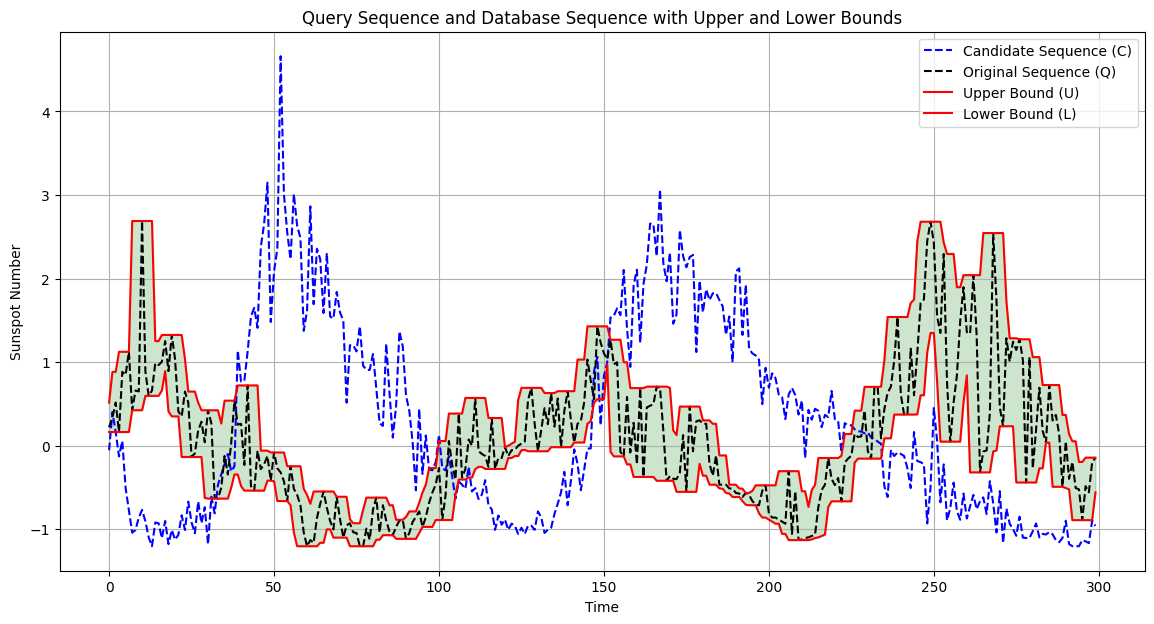

In [102]:
plot_query_database_with_bounds(y, x, U, L)

In summary, the plot visualizes how LB_Keogh computes a lower bound on the DTW distance by considering only the points of C that fall outside the bounding envelopes of Q. This can significantly speed up the process of DTW because it allows us to avoid full DTW calculations if the lower bound is greater than some threshold of interest.

## 5. Indexing DTW

We have denoted a time serie as $C = c_1, c_2, c_n, \ldots$.

Let $N$ be the dimensionality of the space we wish to index.

$$1 \leq N\leq n$$

A time series $C$ of length $n$ can be represented as a set of $N$-dimensional space by a vector:

$$ \bar{C} = (\bar{c_1}, \bar{c_2}, \ldots, \bar{c_N})$$

The $i$-th element of $\bar{C}$ is defined as:

$$\bar{c_i} = \frac{N}{n} \sum_{j=\frac{n}{N}(i-1)+1}^{\frac{n}{N}i} c_j$$

In [103]:
# plot the query sequence and the PAA
dim = 16
paa_original = paa(x, dim)
paa_candidate = paa(y, dim)

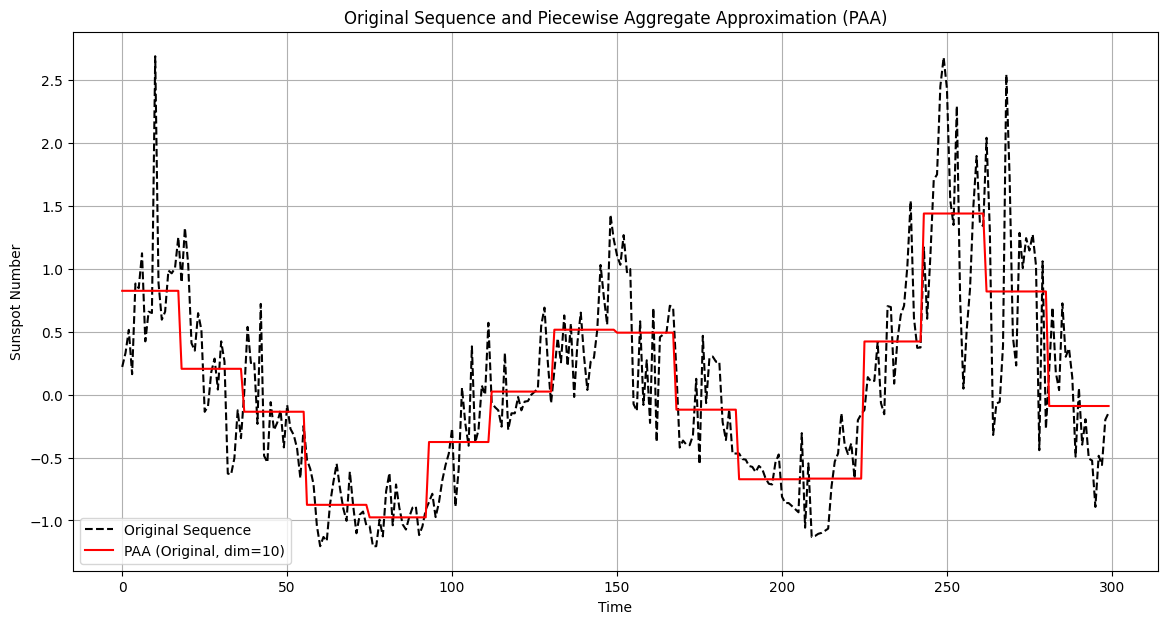

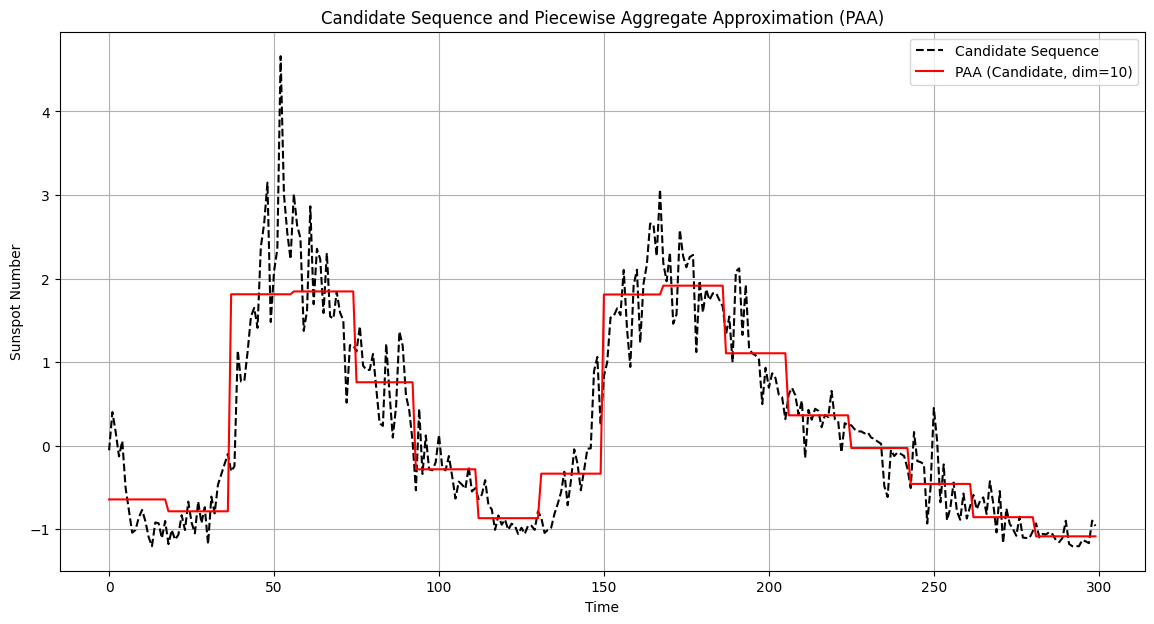

In [104]:
plot_sequence_with_paa(x, paa_original, 'Original')
plot_sequence_with_paa(y, paa_candidate, 'Candidate')

Given two original time series $C$ and $Q$, we can represent them as $\bar{C}$ and $\bar{Q}$ as described above.

### 3.1. Modifying PAA to index time-warped queries


Before we computed the lowering bounding measure LB_Keogh. However, calculating the LB_Keogh requires n values. Because n may be in the order of hundreds to thousands and multidimensional index structures begin to degrade rapidly somewhere above 16 dimensions, we need a way to create a lower, N-dimension version of the function, where N is a number that can be reasonably handled by a multidimensional index structure. We also need this lower dimension version of the function to lower bound LB_Keogh (and therefore, by transitivity, DTW).

Let's start by creating special piecewise aggregate approximations of U and L, which we will deonte as $\bar{U}$ and $\bar{L}$.

$$\hat{U_i} = max({U{_{\frac{n}{N}(i-1)+1}}, \dots, U{_{\frac{n}{N}(i)}}})$$

$$\hat{L_i} = min({L{_{\frac{n}{N}(i-1)+1}}, \dots, L{_{\frac{n}{N}(i)}}})$$

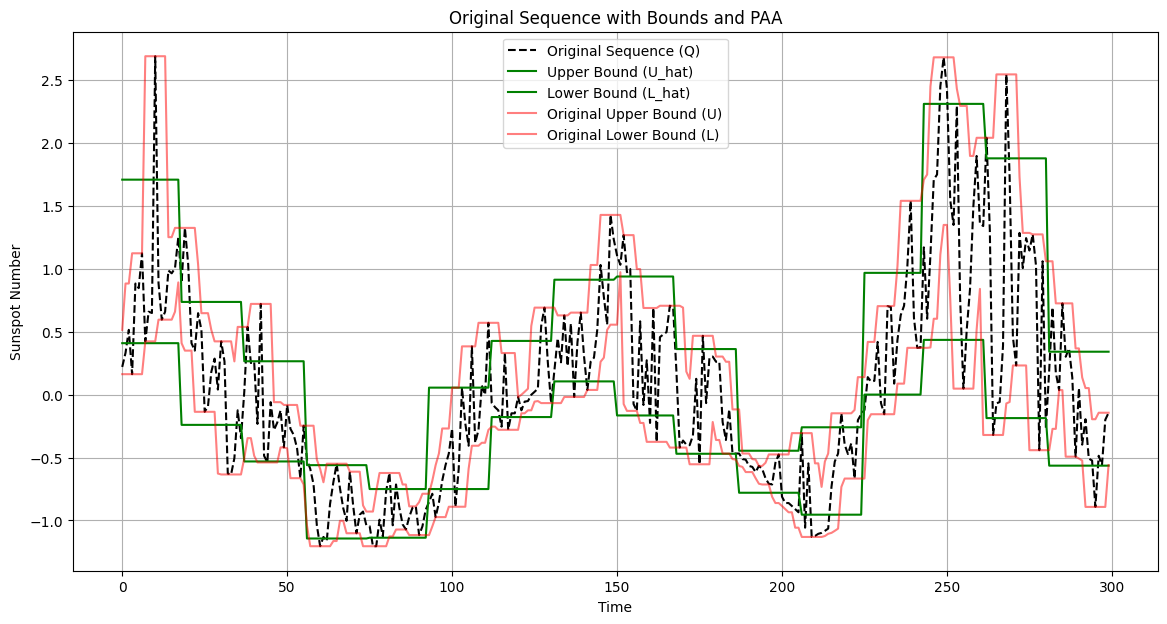

In [105]:
U_hat = paa(U, dim)
L_hat = paa(L, dim)

plot_sequence_with_bounds_and_paa(x, U, L, U_hat, L_hat)

We can now defined the low dimension version of LB_Keogh as follows, which is denoted as LB_PAA. Given a candidate sequence C, transformed to $\bar{C}$, and a query sequence Q, with its companion PAA functions $\hat{U}$ and $\hat{L}$, the following function lower bounds LB_Keogh:

$$ LB_{PAA}(Q,\bar{C}) = \sqrt{\sum_{i=1}^{N} 
\begin{cases} 
(\bar{c_i} - \hat{U_i})^2 & \text{if } \bar{c_i} > \hat{U_i} \\
(\bar{c_i} - \hat{L_i})^2 & \text{if } \bar{c_i} < \hat{L_i} \\
0 & \text{otherwise}

\end{cases}
} $$

Now, the final step is to define a $MINDIST$ function that can be used to index time series. The $MINDIST$ function is defined as follows:


$$ MINDIST(Q,R) = \sqrt{\sum_{i=1}^{N} \frac {n}{N}
\begin{cases} 
(l_i - \hat{U_i})^2 & \text{if } l_i > \hat{U_i} \\
(h_i - \hat{L_i})^2 & \text{if } h_i < \hat{L_i} \\
0 & \text{otherwise}
\end{cases}
} $$

where:

$L = {l_1, l_2, \ldots, l_N}$

$H = {h_1, h_2, \ldots, h_N}$

and R is the major diagonal.

By definition, R is the smallest rectangle that contains eacg PAA point $\bar{C} = {\bar{c_1}, \bar{c_2}, \ldots, \bar{c_N}}$ stored in $U$.

Now, that we defined $LB_{PAA}$ and $MINDIST(Q,R)$, we can introduce the K-NN algorithm.

A query $KNNSearch(Q, k)$  with a query sequence $Q$ and a parameter $k$, returns the $k$ nearest neighbors of $Q$ in the time series database. 

The distance of an object $C$ from $Q$ is defined by the $LB_{PAA}(Q,\bar{C})$ function, while the distance of a node $U$ from $Q$ is defined by the $MINDIST(Q,R)$ function of the minimum bouding rectangle (MBR) $R$ that contains $U$ from $Q$.

### 3.2. K-NN Search Algorithm

In [106]:
indexed_structure = IndexedStructure(paa_size=16)
for i in range(0, len(sunspots), 300):
    indexed_structure.insert(sunspots[i:i+300])

knn_search(indexed_structure, x, 3)

[(array([ 2.19787658e-01,  3.31734646e-01,  5.14384994e-01,  1.62341178e-01,
          8.82631664e-01,  8.45806997e-01,  1.12272849e+00,  4.23059820e-01,
          6.58737689e-01,  6.48426782e-01,  2.68851333e+00,  8.87050624e-01,
          5.95399262e-01,  6.58737689e-01,  9.85740732e-01,  9.63645932e-01,
          1.00488956e+00,  1.25087833e+00,  8.91469584e-01,  1.32452767e+00,
          1.03434929e+00,  4.08329953e-01,  3.49410486e-01,  6.46953795e-01,
          5.14384994e-01, -1.36675118e-01, -9.24855177e-02,  1.80017018e-01,
          2.86072059e-01,  4.00832835e-02,  4.23059820e-01,  2.63977259e-01,
         -6.27179682e-01, -6.34544616e-01, -5.04921788e-01, -1.24891225e-01,
         -3.45839227e-01,  2.24074433e-02,  5.37952781e-01,  2.50720379e-01,
          2.61031285e-01, -2.32419252e-01,  7.20603129e-01, -4.85772961e-01,
         -5.38800482e-01, -6.00798107e-02, -2.81027813e-01, -2.22108346e-01,
         -1.24891225e-01, -4.19488561e-01, -8.21746109e-02, -2.72189893e-01,

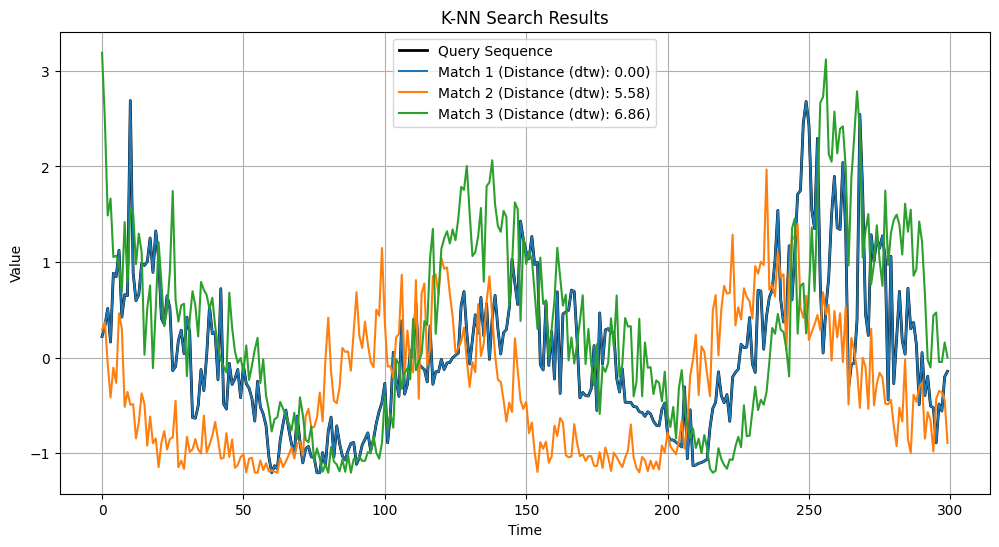

In [107]:
query_sequence = sunspots[:300]
U_hat, L_hat = create_paa_bounds(query_sequence, r, dim)
knn_search_results = knn_search(indexed_structure, query_sequence, k=3,)
plot_matches_knn_search(query_sequence, knn_search_results)

### 3.3. Range Search Algorithm

In [108]:
epsilon = 10
query_sequence = sunspots[:300]
query_paa = indexed_structure.paa(query_sequence)
results = range_search(query_paa, epsilon, indexed_structure.root, query_sequence, U_hat, L_hat)
print(f"Number of sequences found within epsilon range: {len(results)}")

Number of sequences found within epsilon range: 9


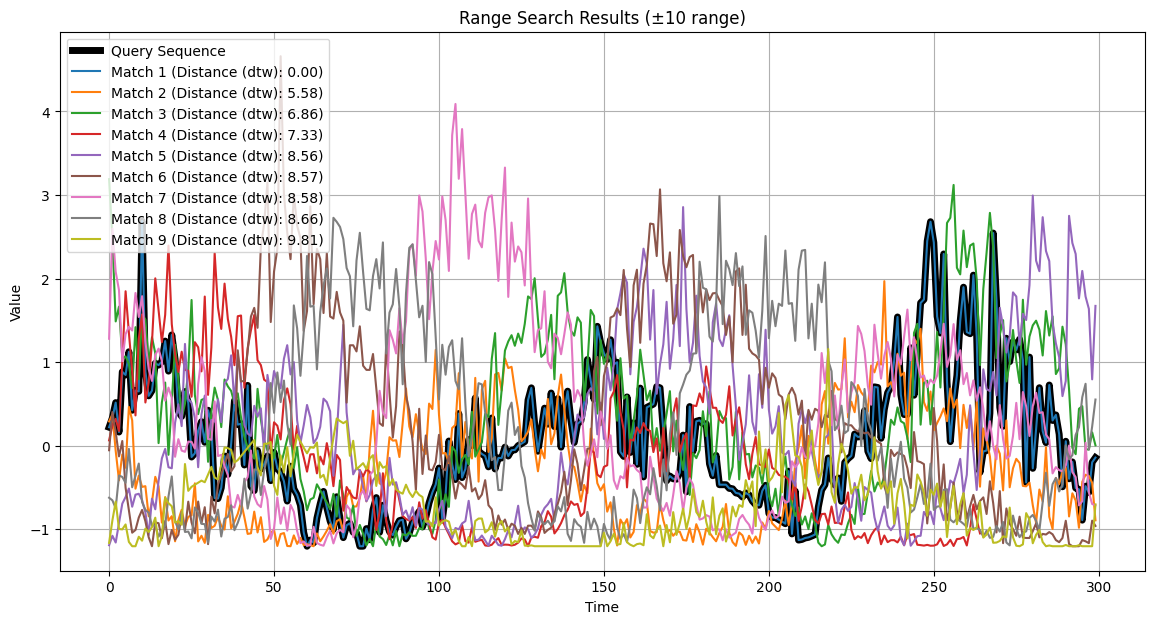

In [109]:
if results:
    plot_range_search_results(query_sequence, results)
else:
    print("No matches found")

In [110]:
for entry in indexed_structure.root.entries[:10]: 
    lb_distance = lb_paa(entry.paa_representation, U_hat, L_hat)
    actual_distance = dtw_distance(query_sequence, entry.original_sequence)
    print(f"LB_PAA: {lb_distance}, DTW: {actual_distance}")

LB_PAA: 2.7427834870161663, DTW: 0.0
LB_PAA: 3.1729682076667993, DTW: 8.572376255507768
LB_PAA: 4.688435447965529, DTW: 9.814380809195512
LB_PAA: 2.98145725549059, DTW: 12.078723843815293
LB_PAA: 2.6621220119580067, DTW: 6.862251152499725
LB_PAA: 3.7287294086701457, DTW: 5.577465958797036
LB_PAA: 4.0177866933378, DTW: 10.044110828201385
LB_PAA: 3.0527409340390395, DTW: 8.55676434546958
LB_PAA: 2.9667562354667063, DTW: 8.584740254292239
LB_PAA: 3.238351618061785, DTW: 8.655176852564013


Since our data has a large scale, even small percentage differences will result in a large DTW distances. Therefore, we normalize the data in order to make the data more comparable. Without normalization, it was necessary to use a really high epsilon value to find any matches in the algorithm range search.

## 6. UCR Archive 2015

In [111]:
from data_preprocessing import load_data_UCR

data_dir = "UCR_TS_Archive_2015"
dataset_name = "Plane"

In [112]:
train_data, test_data = load_data_UCR(data_dir, dataset_name)
train_data.shape, test_data.shape

((105, 145), (105, 145))

In [113]:
train_labels = train_data[:, 0] # first column is the label
train_features = train_data[:, 1:] # the rest of the columns are the features

test_labels = test_data[:, 0]
test_features = test_data[:, 1:]

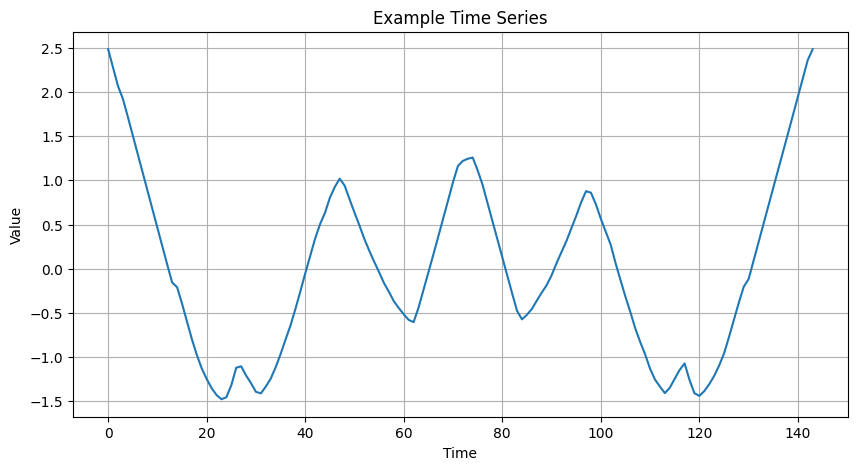

In [114]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_features[0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Example Time Series')
plt.grid()
plt.show()

### 5.1. KNN Search

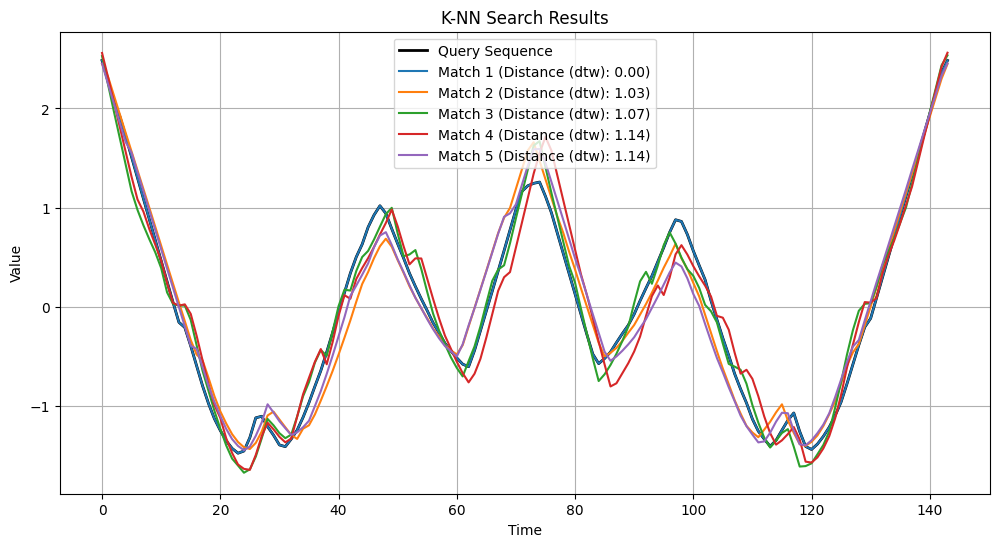

In [115]:
# Now, we will build the indexed structure with the training data
indexed_structure = IndexedStructure(paa_size=16)

# Inserting each training time series into the indexed structure
for timeseries in train_features:
    indexed_structure.insert(timeseries)

# Query sequence
query_sequence = train_features[0]

# Create PAA bounds for the query sequenced
dim = 16
U_hat, L_hat = create_paa_bounds(query_sequence, r, dim)

# Perform the KNN search
knn_search_results = knn_search(indexed_structure, query_sequence, k=5)

# Plot the matches
plot_matches_knn_search(query_sequence, knn_search_results)

### 5.2. Range Search

Found 6 sequences within an epsilon of 4.25


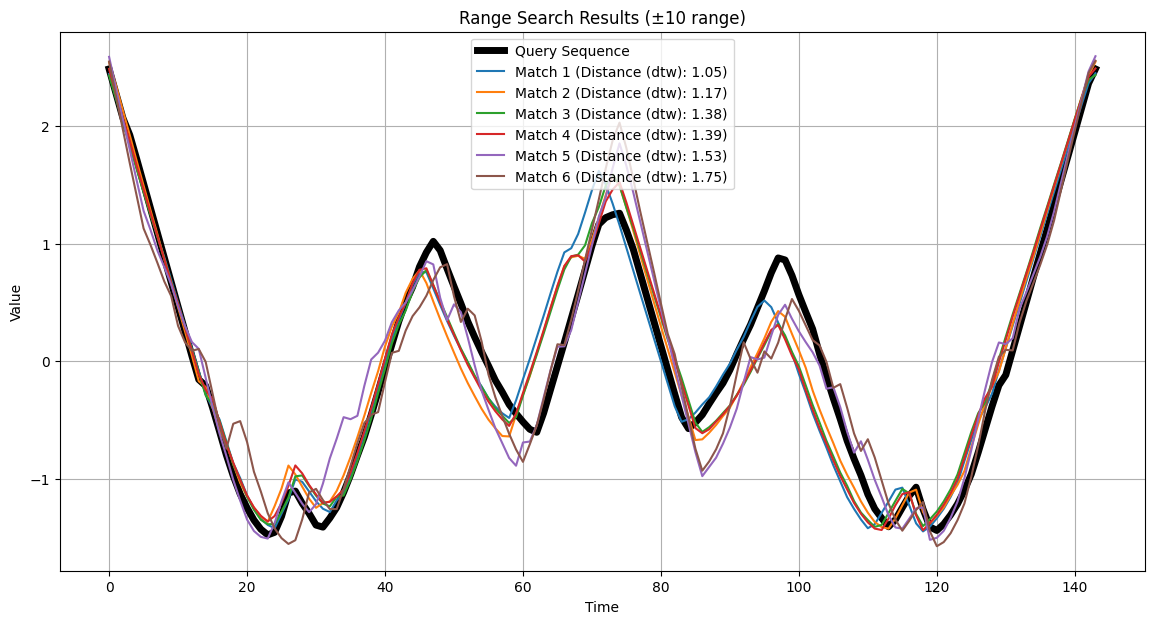

In [116]:
query_paa = indexed_structure.paa(query_sequence)
epsilon = 4.25

# Calculate PAA bounds for the query sequence
dim = 16
U_hat, L_hat = create_paa_bounds(query_sequence, r=3, dim=dim)

# Now perform the range search
results = range_search(query_paa, epsilon, indexed_structure.root, query_sequence, U_hat, L_hat)

print(f"Found {len(results)} sequences within an epsilon of {epsilon}")

if results:
    plot_range_search_results(query_sequence, results)
else:
    print("No matches found")

## 7. Experimental evaluation

### 6.1. Tightness of the Lower Bound

$$\text{Tightness} = T = \frac{\text{Lower Bound Estimate of Dynamic Time Warp Distance}(Q,C)}{\text{True Dynamic Time Warp Distance}(Q,C)}$$

In [117]:
# Extract 50 sequences of length 256 from the dataset
query = test_features[np.random.choice(len(test_features), 50, replace=False)]
query = query[:, :256]

# Compute T for each lower bounding function
T_Yi, T_Kim, T_Keogh = compute_T(query)

print(f"T ratio for LB_Yi: {T_Yi}")
print(f"T ratio for LB_Kim: {T_Kim}")
print(f"T ratio for LB_Keogh: {T_Keogh}")

T ratio for LB_Yi: 0.06695510887643578
T ratio for LB_Kim: 0.11187558823212333
T ratio for LB_Keogh: 0.9314621028024707


In [118]:
# run for different query lengths
query_lengths = [16, 32, 64, 128, 256, 512, 1024]

T_results = perform_experiment_T(test_features, query_lengths)

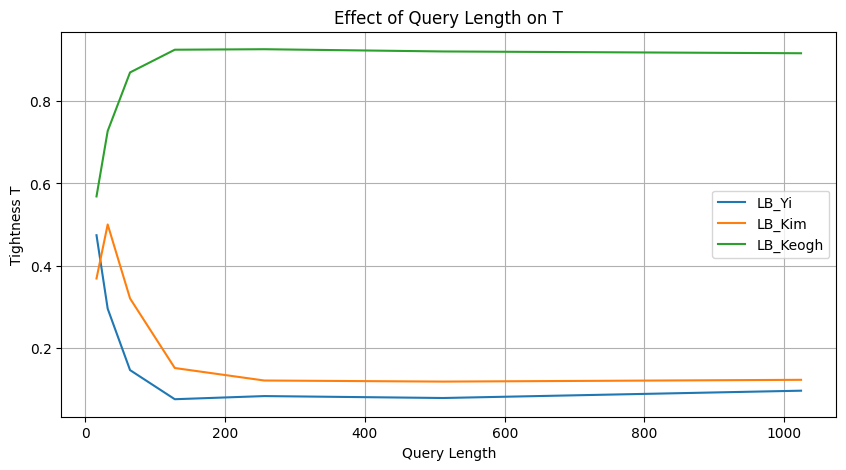

In [119]:
plt.figure(figsize=(10, 5))
for method in ['yi', 'kim', 'keogh']:
    plt.plot(query_lengths, [T_results[length][method] for length in query_lengths],
             label=f'LB_{method.capitalize()}')
plt.xlabel('Query Length')
plt.ylabel('Tightness T')
plt.title('Effect of Query Length on T')
plt.legend()
plt.grid()
plt.show()

### 6.2. Pruning Power of the Lower Bound

$$ \text{Pruning Power} = P = \frac{\text{Number of objects that do not require full DTW}}{\text{Number of objects in database}}$$

In [120]:
# Extract 50 sequences of length 256 from the dataset
query = test_features[np.random.choice(len(test_features), 50, replace=False)]

# Compute the Pruning Power (P) for each method
P_Yi, P_Kim, P_Keogh = compute_P(query, test_features)

print(f"Pruning Power (P) for LB_Yi: {P_Yi}")
print(f"Pruning Power (P) for LB_Kim: {P_Kim}")
print(f"Pruning Power (P) for LB_Keogh: {P_Keogh}")

Pruning Power (P) for LB_Yi: 0.04
Pruning Power (P) for LB_Kim: 0.2
Pruning Power (P) for LB_Keogh: 0.4


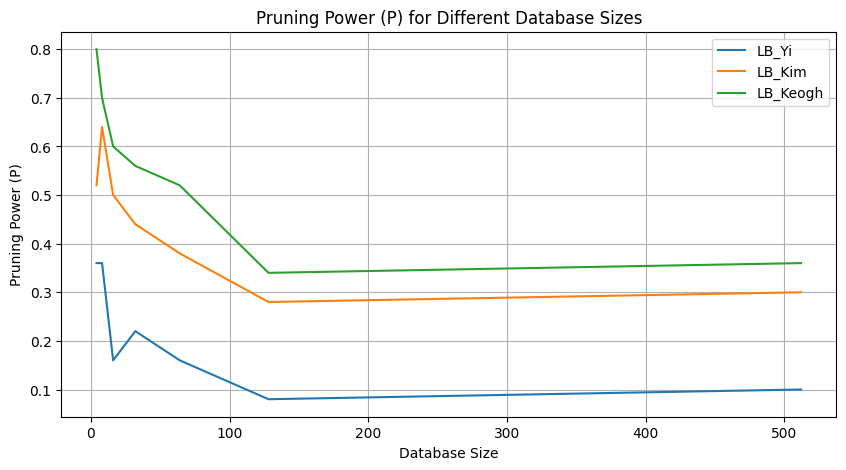

In [121]:
# Define the database sizes
database_sizes = [4, 8, 16, 32, 64, 128, 512]

# Lists to store pruning powers for each database size
P_Yi_values = []
P_Kim_values = []
P_Keogh_values = []

# For each database size, compute the Pruning Power (P) for each method
for size in database_sizes:
    # Extract 50 sequences of length 256 from the dataset
    query = test_features[np.random.choice(len(test_features), 50, replace=False)]
    query = query[:, :256]

    # Compute the Pruning Power (P) for each method
    P_Yi, P_Kim, P_Keogh = compute_P(query, test_features[:size])

    P_Yi_values.append(P_Yi)
    P_Kim_values.append(P_Kim)
    P_Keogh_values.append(P_Keogh)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(database_sizes, P_Yi_values, label='LB_Yi')
plt.plot(database_sizes, P_Kim_values, label='LB_Kim')
plt.plot(database_sizes, P_Keogh_values, label='LB_Keogh')
plt.xlabel('Database Size')
plt.ylabel('Pruning Power (P)')
plt.title('Pruning Power (P) for Different Database Sizes')
plt.legend()
plt.grid()
plt.show()

In [122]:
data_set_size = len(test_features)
data = [
    {'ID': 1, 'Name': 'Plane', 
      'T_Yi': T_Yi, 'T_Kim': T_Kim, 'T_Keogh': T_Keogh, 'P_Yi': P_Yi, 'P_Kim': P_Kim, 'P_Keogh': P_Keogh}
]

pd.DataFrame(data)

,ID,Name,T_Yi,T_Kim,T_Keogh,P_Yi,P_Kim,P_Keogh
0,1,Plane,0.066955,0.111876,0.931462,0.1,0.3,0.36
